# Description

After the manuscript revision, here I analyze each gene pair in Figure 3b to see which one can be replaced taking into account the significance of the correlation coefficients.

# Modules loading

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from ccc import conf

# Settings

In [3]:
GTEX_TISSUE = "whole_blood"
GENE_SEL_STRATEGY = "var_pc_log2"
# Configuration constants
TOP_N_GENES = "all"
DATA_DIR = Path("/mnt/data/proj_data/ccc-gpu/gene_expr/data/gtex_v8")
GENE_SELECTION_DIR = DATA_DIR / "gene_selection" / TOP_N_GENES
SIMILARITY_MATRICES_DIR = DATA_DIR / "similarity_matrices" / TOP_N_GENES

# Paths

In [4]:
MANUSCRIPT_DIR = Path("/mnt/data/projs/manuscripts/ccc-gpu/")
assert MANUSCRIPT_DIR.exists(), "Manuscript dir not found"

In [5]:
OUTPUT_DATA_DIR = MANUSCRIPT_DIR / "results"
assert OUTPUT_DATA_DIR.exists()
display(OUTPUT_DATA_DIR)

PosixPath('/mnt/data/projs/manuscripts/ccc-gpu/results')

In [6]:
OUTPUT_FIGURE_DIR = MANUSCRIPT_DIR / "figures" / "coefs_comp" / f"gtex_{GTEX_TISSUE}"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/mnt/data/projs/manuscripts/ccc-gpu/figures/coefs_comp/gtex_whole_blood')

In [7]:
INPUT_GENE_EXPR_FILE = (
    GENE_SELECTION_DIR / f"gtex_v8_data_{GTEX_TISSUE}-{GENE_SEL_STRATEGY}.pkl"
)
display(INPUT_GENE_EXPR_FILE)

assert INPUT_GENE_EXPR_FILE.exists()

PosixPath('/mnt/data/proj_data/ccc-gpu/gene_expr/data/gtex_v8/gene_selection/all/gtex_v8_data_whole_blood-var_pc_log2.pkl')

In [8]:
INPUT_GENE_PAIRS_INTERSECTIONS_FILE = (
    OUTPUT_DATA_DIR
    / f"gene_pair_intersections-gtex_v8-{GTEX_TISSUE}-{GENE_SEL_STRATEGY}.pkl"
)
display(INPUT_GENE_PAIRS_INTERSECTIONS_FILE)

assert INPUT_GENE_PAIRS_INTERSECTIONS_FILE.exists()

PosixPath('/mnt/data/projs/manuscripts/ccc-gpu/results/gene_pair_intersections-gtex_v8-whole_blood-var_pc_log2.pkl')

In [9]:
INPUT_PVALUES_FILE = OUTPUT_DATA_DIR / "pvalues" / "gene_pair-samples-pvalues-fdr.pkl"
display(INPUT_PVALUES_FILE)
assert INPUT_PVALUES_FILE.exists()

PosixPath('/mnt/data/projs/manuscripts/ccc-gpu/results/pvalues/gene_pair-samples-pvalues-fdr.pkl')

# Data

## Gene Ensembl ID -> Symbol mapping

In [10]:
gene_map = pd.read_pickle(MANUSCRIPT_DIR / "data" / "gtex_gene_id_symbol_mappings.pkl")

In [11]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [12]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

## Gene expression

In [13]:
gene_expr_df = pd.read_pickle(INPUT_GENE_EXPR_FILE)

In [14]:
gene_expr_df.shape

(56200, 755)

In [15]:
gene_expr_df.head()

,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-1128S-0005-SM-5P9HI,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117XS-0005-SM-5PNU6,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,...,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVP2-0005-SM-51MRK,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVTK-0006-SM-57WBK,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXES-0005-SM-57WCB,GTEX-ZXG5-0005-SM-57WCN
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000169429.10,0.5623,0.8067,116.90000,4.047,211.0,58.110,68.38,249.50,5.095,295.9,...,39.960,0.1393,0.22380,245.0,513.6,1626.00,0.5633,515.70,1.19400,1163.00
ENSG00000135245.9,0.6529,1.3850,199.20000,2.266,116.7,192.300,161.50,263.50,23.540,251.9,...,114.300,1.8330,0.41150,149.0,935.3,233.60,0.8882,134.00,1.12000,295.70
ENSG00000163631.16,1.8480,0.2503,0.08429,1.251,1348.0,9.971,101.30,95.09,1.264,119.3,...,2.092,2.1100,0.03588,171.8,107.1,71.25,1.7720,309.60,0.07361,17.75
ENSG00000277632.1,1.6960,1.3450,235.10000,11.770,141.7,199.100,525.50,659.90,10.910,209.3,...,61.340,2.2500,0.72310,261.2,400.0,288.50,2.6960,287.50,3.32300,618.90
ENSG00000239839.6,185.2000,1.7790,694.30000,23.840,297.3,3122.000,2521.00,1504.00,80.060,652.0,...,1010.000,253.8000,94.52000,6083.0,2768.0,52.06,34.5700,17.36,352.30000,63.85


## p-values

In [16]:
df_pvalues = pd.read_pickle(INPUT_PVALUES_FILE).sort_index()

In [17]:
df_pvalues.shape

(17008, 10)

In [18]:
df_pvalues.head()

group  \
gene0              gene1                                                                
ENSG00000000005.5  ENSG00000243101.1                  ccc_high_and_pearson_low-random   
ENSG00000000938.12 ENSG00000104419.14                ccc_high_and_spearman_low-random   
ENSG00000001167.14 ENSG00000105514.7                ccc_high_and_spearman_low-top_ccc   
                   ENSG00000115271.10  ccc_high_and_spearman_pearson_low-top_spearman   
                   ENSG00000120696.8    ccc_high_and_spearman_pearson_low-top_pearson   

                                            ccc  ccc_fdr  ccc_pvalue  \
gene0              gene1                                               
ENSG00000000005.5  ENSG00000243101.1   0.048498  0.06842    0.036963   
ENSG00000000938.12 ENSG00000104419.14  0.060396  0.00228    0.000999   
ENSG00000001167.14 ENSG00000105514.7   0.117324  0.00228    0.000999   
                   ENSG00000115271.10  0.046347  0.00228    0.000999   
                   ENSG00000120696.8   0.062453  0.00228    0.000999   

                                        pearson  pearson_fdr  pearson_pvalue  \
gene0              gene1                                                       
ENSG00000000005.5  ENSG00000243101.1   0.007716     0.983834        0.832370   
ENSG00000000938.12 ENSG00000104419.14 -0.035049     0.688565        0.336168   
ENSG00000001167.14 ENSG00000105514.7  -0.080593     0.060727        0.026801   
                   ENSG00000115271.10 -0.015264     0.979229        0.675394   
                   ENSG00000120696.8  -0.016073     0.979229        0.659266   

                                       spearman  spearman_fdr  spearman_pvalue  
gene0              gene1                                                        
ENSG00000000005.5  ENSG00000243101.1   0.060663      0.253941         0.095789  
ENSG00000000938.12 ENSG00000104419.14  0.013827      0.927365         0.704447  
ENSG00000001167.14 ENSG00000105514.7   0.007112      0.987225         0.845319  
                   ENSG00000115271.10  0.022135      0.866054         0.543673  
                   ENSG00000120696.8  -0.008079      0.980615         0.824607

In [19]:
# remove duplicated gene pairs
df_pvalues = df_pvalues[~df_pvalues.index.duplicated(keep="first")]

**Note**: Here the "group" column specifies the categories in Figure 3a, followed by `top_[coef]`, where for the same category I sorted gene pairs by `coef`. This allows me, for instance, to take the gene pairs where Pearson is high and CCC is low, and sort by any of those coefficient values.

## Functions

In [20]:
def plot_gene_pair(top_pairs_df, idx, bins="log", plot_gene_ids=True):
    """
    It plots a gene pair using a hexbin plot. The idea of this function is
    to quickly have an idea of the patterns (if any) present in a couple genes.

    Args:
        top_pairs_df: a dataframe with a preselected group of genes pairs (for instance,
            those where pearson is high and ccc is low. Each row is a gene pair.
            It is the output of function get_gene_pairs.
        idx: an integer that indicates which row in top_pairs_df you want to plot.
        bins: the "bins" parameter of seaborn's jointplot.
        plot_gene_ids: it adds genes' Ensembl IDs to the x and y labels.

    Returns:
        The JointGrid object returned by seaborn.jointplot.
    """
    gene0, gene1 = top_pairs_df.iloc[idx].name
    display((gene0, gene1))

    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    _pearson, _pearson_fdr, _spearman, _spearman_fdr, _ccc, _ccc_fdr = top_pairs_df.loc[
        (gene0, gene1),
        ["pearson", "pearson_fdr", "spearman", "spearman_fdr", "ccc", "ccc_fdr"],
    ].tolist()

    p = sns.jointplot(
        data=gene_expr_df.T,
        x=gene0,
        y=gene1,
        kind="hex",
        bins=bins,
        # ylim=(0, 500),
    )

    gene_x_id = p.ax_joint.get_xlabel()
    gene_x_symbol = gene_map[gene_x_id]

    gene_y_id = p.ax_joint.get_ylabel()
    gene_y_symbol = gene_map[gene_y_id]

    if plot_gene_ids:
        p.ax_joint.set_xlabel(f"{gene_x_id}\n{gene_x_symbol}")
        p.ax_joint.set_ylabel(f"{gene_y_id}\n{gene_y_symbol}")
    else:
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

    _title = f"$c={_ccc:.2f}$ (${_ccc_fdr:.2e}$)  $p={_pearson:.2f}$ (${_pearson_fdr:.2e}$)    $s={_spearman:.2f}$ (${_spearman_fdr:.2e}$)"
    p.fig.suptitle(_title)

    return p

# Analyze current gene pairs in Figure 3b (before manuscript revision)

Here I look at all the current gene pairs in Figure 3b. We have to decide on whether keep them or remove them.
This is bacause after doing the p-value analysis and looking for significant gene pairs across all correlation coefficients, we want to keep some pairs where, for example, CCC is high and significant and Pearson is low but also nonsignificant.
Also, if possible and does not affect the conclusions, we want to keep those gene pairs that we are already discussing in the manuscript.

Here I look at the current gene pairs, and then I also use notebook `nbs/99_manuscript/coefs_comp/08_05-gtex_whole_blood-intersections_plots.ipynb` to sort gene pairs considering *both* the coefficient value and p-values.
I write down here the decision on each gene pair (keep or replace) and the reasons.

## IFNG vs SDS

**Decision:** Keep, because:
* Very high CCC value, although Pearson is significant also.
* *SDS* is a gene with fewer publications than expected, we are mentioning this argument in the manuscript.

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000135094.10,ENSG00000111537.4,selected_in_manuscript,0.706993,0.00228,0.000999,0.090451,0.029895,0.012907,0.765177,5.356577e-145,3.793991e-146


('ENSG00000135094.10', 'ENSG00000111537.4')

('SDS', 'IFNG')

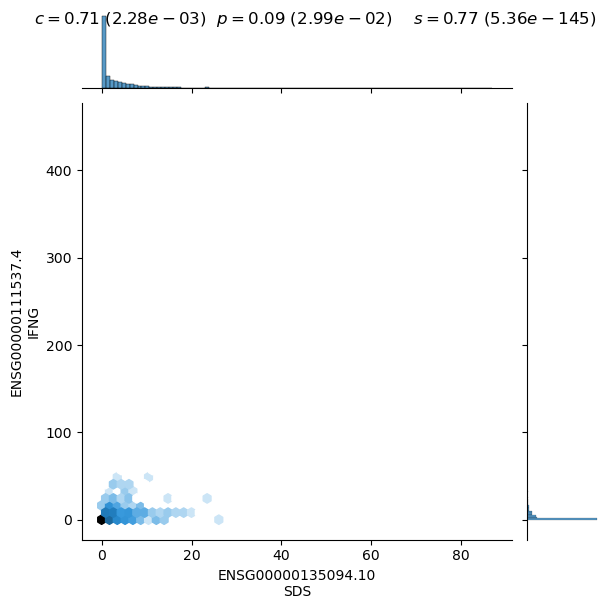

In [21]:
gene0_id = "ENSG00000135094.10"
gene1_id = "ENSG00000111537.4"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)

## ~JUN vs APOC1~

**Decision:** Remove and do not replace, because:
* Very high CCC value, but Pearson is significant also.
* And we do not discuss any of these genes in the manuscript.
* And we do not need another example of this category.

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000130208.9,ENSG00000177606.6,selected_in_manuscript,0.612233,0.00228,0.000999,0.084623,0.045814,0.020044,0.748265,3.346193e-135,2.430887e-136


('ENSG00000130208.9', 'ENSG00000177606.6')

('APOC1', 'JUN')

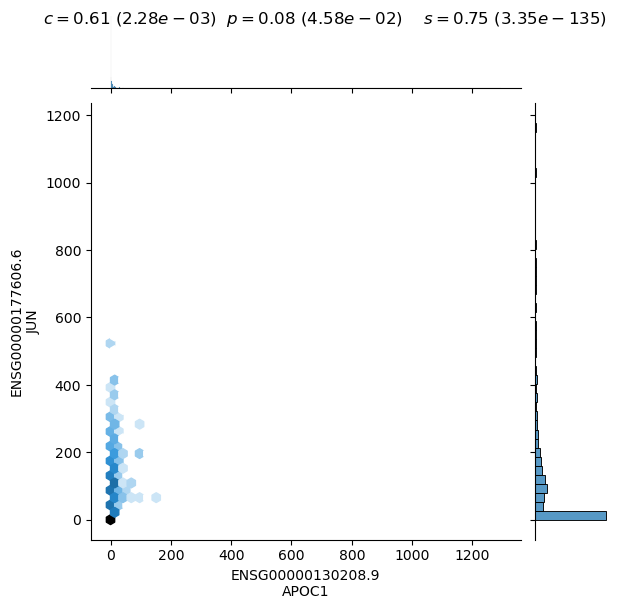

In [22]:
gene0_id = "ENSG00000130208.9"
gene1_id = "ENSG00000177606.6"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)

In [23]:
# Initially, I though in replacing it by LIF vs APOC1

# gene0_id = "ENSG00000130208.9"
# gene1_id = "ENSG00000128342.4"

# _tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
# display(_tmp)

# p = plot_gene_pair(_tmp, 0)
# display(p)

## ~ZDHHC12 vs CCL18~ CCL18 vs PRSS36

**Decision:** Replace, because:
* Significant in all coefficients.
* Although we discuss ZDHHC12 as a little studied gene, the ZDHHC family has more studies.
* Not strong link of ZDHHC12 to the rest of the network: https://hb.flatironinstitute.org/gene/84885+6362

*Replaced by:* CCL18 vs PRSS36

* High CCC, low Pearson and not significant, although still significant with Spearman.
* Predicted to be expressed in macrophage in GIANT: https://hb.flatironinstitute.org/gene/6362+146547

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000275385.1,ENSG00000160446.18,selected_in_manuscript,0.446659,0.00228,0.000999,-0.099853,0.014263,0.006033,-0.560171,1.189280e-62,1.379070e-63


('ENSG00000275385.1', 'ENSG00000160446.18')

('CCL18', 'ZDHHC12')

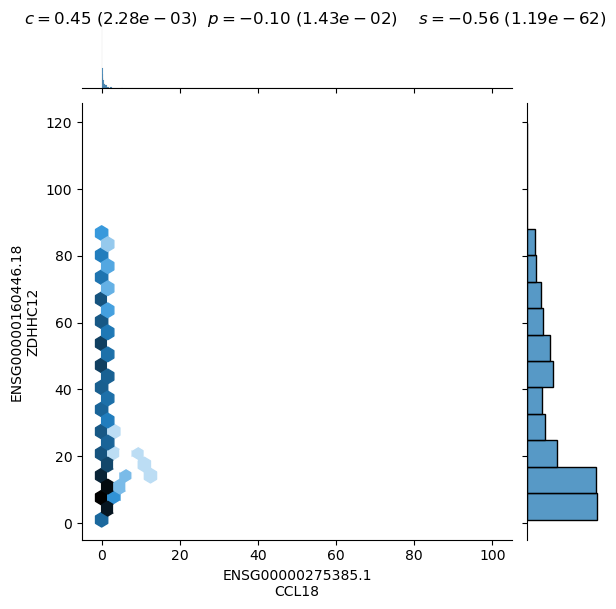

In [24]:
gene0_id = "ENSG00000275385.1"
gene1_id = "ENSG00000160446.18"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)

## UTY vs KDM6A

**Decision:** Keep, because:
* They are genes in the sex chromosomes.
* Figure 4 is about them.
* A drawback is that all coefficients are significant. However, in other GTEx tissues (Figure 4) it is possible to see that only CCC captures this pattern consistently.

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000147050.14,ENSG00000183878.15,selected_in_manuscript,0.294391,0.00228,0.000999,0.23987,9.788206e-11,2.425885e-11,0.100621,0.018482,0.005653


('ENSG00000147050.14', 'ENSG00000183878.15')

('KDM6A', 'UTY')

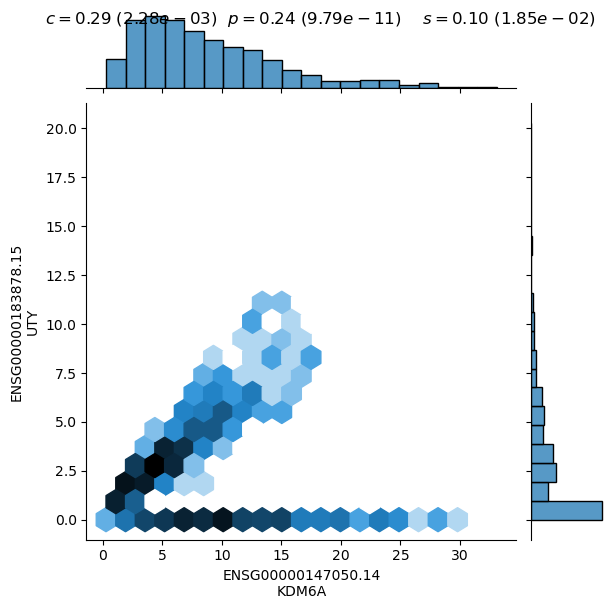

In [39]:
gene0_id = "ENSG00000147050.14"
gene1_id = "ENSG00000183878.15"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)

p.savefig(OUTPUT_FIGURE_DIR / "UTY_vs_KDM6A.svg", format="svg")
p.savefig("./UTY_vs_KDM6A.svg", format="svg")

## RASSF2 vs CYTIP + KDM6A vs DDX3Y

**Decision:** Keep and add another, because:
* Nice example of two embedded linear relationships.
* Although all coefficients are significant, we can add another example in this category (KDM6A vs DDX3Y) where spearman is not significant.
* Predicted to be expressed in leukocytes in GIANT: https://hb.flatironinstitute.org/gene/9770+9595

*Add another pair:* KDM6A vs DDX3Y

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000115165.9,ENSG00000101265.15,selected_in_manuscript,0.201962,0.00228,0.000999,-0.15606,0.000044,0.000017,-0.107882,0.010038,0.002997


('ENSG00000115165.9', 'ENSG00000101265.15')

('CYTIP', 'RASSF2')

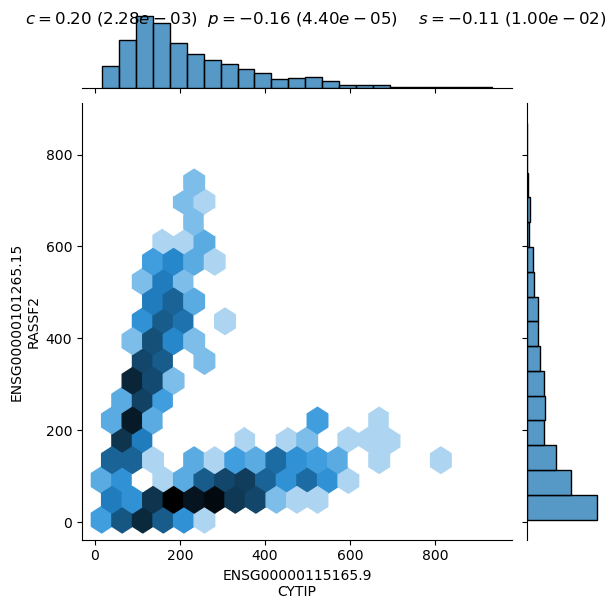

In [40]:
gene0_id = "ENSG00000115165.9"
gene1_id = "ENSG00000101265.15"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)
p.savefig(OUTPUT_FIGURE_DIR / "RASSF2_vs_CYTIP.svg", format="svg")
p.savefig("./RASSF2_vs_CYTIP.svg", format="svg")

## AC068580.6 vs KLHL21

**Decision:** Keep, because:
* We already talk about this gene pair in the text (about KLHL21).
* Pearson is not significant.
* Although spearman is significant, all the other gene pairs in this category are also significant in Spearman. The other gene pair that is less significant for Spearman is C17orf53 vs TPX2 (but not worth replacing).
* Predicted to be expressed in XXX in GIANT: URL_HERE

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000162413.16,ENSG00000235027.1,selected_in_manuscript,0.184217,0.00228,0.000999,0.062875,0.184207,0.084264,-0.186421,9.592856e-07,2.480890e-07


('ENSG00000162413.16', 'ENSG00000235027.1')

('KLHL21', 'AC068580.6')

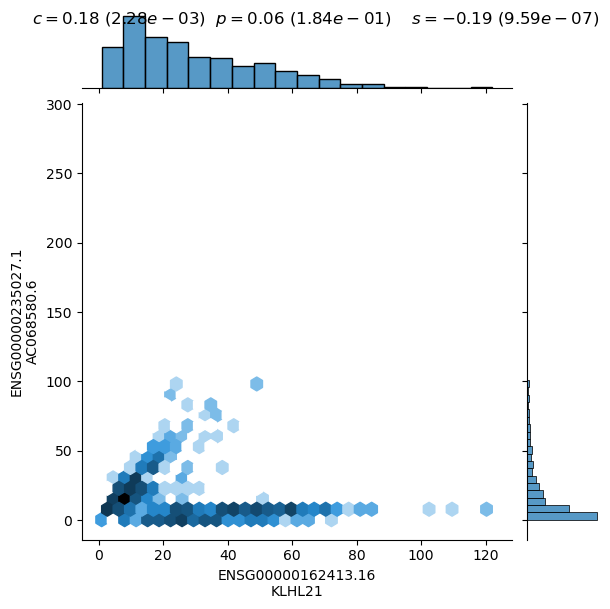

In [41]:
gene0_id = "ENSG00000162413.16"
gene1_id = "ENSG00000235027.1"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)
p.savefig(OUTPUT_FIGURE_DIR / "AC068580.6_vs_KLHL21.svg", format="svg")
p.savefig("./AC068580.6_vs_KLHL21.svg", format="svg")

## MYOZ1 vs TNNI2

**Decision:** Keep, because:
* We are already analyzing these gene pair: it's included in Figure 5.
* Pearson value is very high.
* However, all other coefficients are significant.
* Predicted to be expressed in skeletal muscle in GIANT: https://hb.flatironinstitute.org/gene/58529+7136

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000130598.15,ENSG00000177791.11,selected_in_manuscript,0.034593,0.00228,0.000999,0.967834,0.0,0.0,0.284206,8.996782e-15,1.706422e-15


('ENSG00000130598.15', 'ENSG00000177791.11')

('TNNI2', 'MYOZ1')

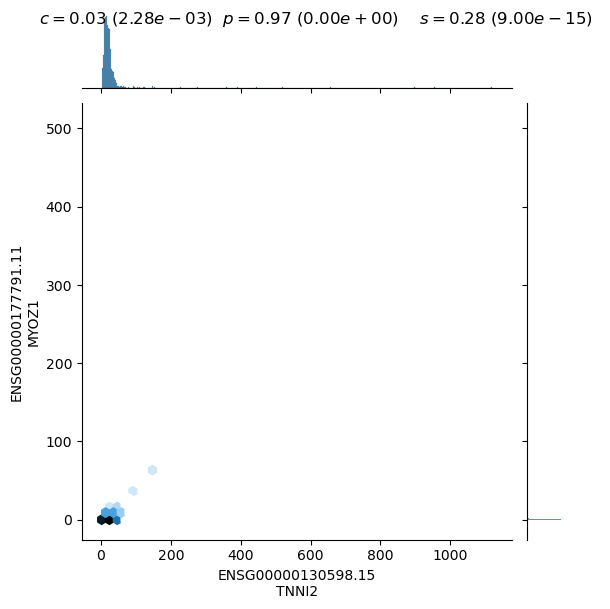

In [30]:
gene0_id = "ENSG00000130598.15"
gene1_id = "ENSG00000177791.11"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)

## ~PYGM vs TPM2~ C19orf33 vs SCGB3A1

**Decision:** Replace, because:
* It's significant in all coefficients.
* Predicted to be expressed in skeletal muscle in GIANT: https://hb.flatironinstitute.org/gene/5837+7169

*Replaced by:* C19orf33 vs SCGB3A1:
* Only significant in Pearson
* Predicted to be expressed in the placenta in GIANT: https://hb.flatironinstitute.org/gene/64073+92304

,,group,ccc,ccc_fdr,ccc_pvalue,pearson,pearson_fdr,pearson_pvalue,spearman,spearman_fdr,spearman_pvalue
gene0,gene1,,,,,,,,,,
ENSG00000198467.13,ENSG00000068976.13,selected_in_manuscript,0.034912,0.00228,0.000999,0.94443,0.0,0.0,0.029852,0.866054,0.412748


('ENSG00000198467.13', 'ENSG00000068976.13')

('TPM2', 'PYGM')

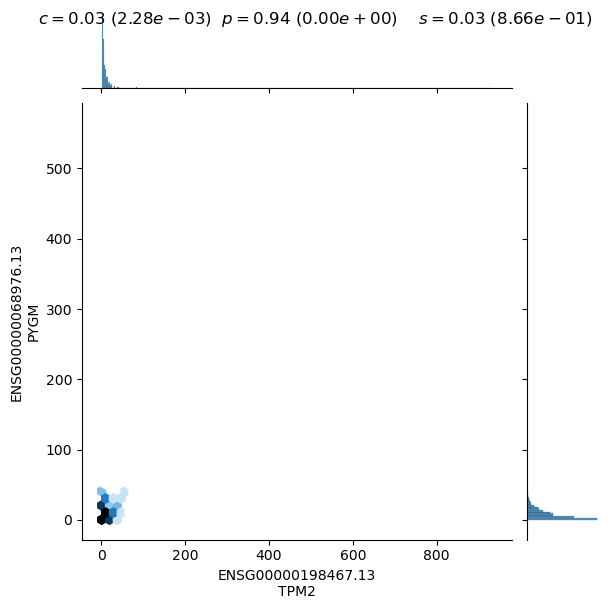

In [31]:
gene0_id = "ENSG00000198467.13"
gene1_id = "ENSG00000068976.13"

_tmp = df_pvalues.loc[[(gene0_id, gene1_id)]]
display(_tmp)

p = plot_gene_pair(_tmp, 0)
display(p)